In [538]:
import numpy as np
import matplotlib.pyplot as plt
from modules import Module, Sequential, Criterion

Implementaion of basic neural network on numpy, understanding main concepts of nn -> backpropogation, batch norm, dropout

In [539]:
class Linear(Module):
    """
    A module which applies a linear transformation 
    A common name is fully-connected layer, InnerProductLayer in caffe. 
    
    The module should work with 2D _input of shape (n_samples, n_feature).
    """
    def __init__(self, n_in, n_out):
        super(Linear, self).__init__()
       
        # This is a nice initialization
        # W - weights, b - bias
        stdv = 1./np.sqrt(n_in)
        self.W = np.random.uniform(-stdv, stdv, size = (n_out, n_in))
        self.b = np.random.uniform(-stdv, stdv, size = n_out)
        
        # grads = 0
        self.gradW = np.zeros_like(self.W)
        self.gradb = np.zeros_like(self.b)
        
    def updateOutput(self, _input):
        # Your code goes here. ################################################
        self.output = np.einsum('ij,jk->ik', _input, self.W) + self.b
        # print( "x_0 -> x_1 = {}".format(self.output))
        return self.output
    
    def updateGradInput(self, _input, gradOutput):
        # Your code goes here. ################################################

        self.gradInput = np.dot(gradOutput, self.W.T)
        print( "parameters of Linear = {}, {}".format(self.W, self.b))
        return self.gradInput
    
    def accGradParameters(self, _input, gradOutput):
        # Your code goes here. ################################################
        # self.gradW = ... ; self.gradb = ...

        #dL/dw = dL/dY * dY/dLogSoftMax * dLogSoftMax/dX_1 * dX_1/dw  X_1 = X_0*w + b -> dX_1/dw = X_0
        self.gradW += np.dot(_input.T, gradOutput)
        #dL/dw = dL/dY * dY/dLogSoftMax * dLogSoftMax/dX_1 * dX_1/db  X_1 = X_0*w + b -> dX_1/db = 1
        self.gradb += np.sum(gradOutput, axis=0)
    
    def zeroGradParameters(self):
        self.gradW.fill(0)
        self.gradb.fill(0)
        
    def getParameters(self):
        return [self.W, self.b]
    
    def getGradParameters(self):
        return [self.gradW, self.gradb]
    
    def __repr__(self):
        s = self.W.shape
        q = 'Linear %d -> %d' %(s[1],s[0])
        return q

In [540]:
class Sigmoid(Module):
    def __init__(self):
        super(Sigmoid, self).__init__()

    def forward(self, input):
        # Calculate sigmoid activation during forward pass
        self.output = 1 / (1 + np.exp(-input))
        return self.output

    def backward(self, input, grad_output):
        # Calculate gradient of the sigmoid function during backward pass
        self.gradInput = self.output * (1 - self.output) * grad_output
        return self.gradInput
    
    def __repr__(self):
        return "Sigmoid"

In [541]:
class SoftMax(Module):
    def __init__(self):
        super(SoftMax, self).__init__()

    def forward(self, input):
        # Calculate softmax
        exp_input = np.exp(input - np.max(input, axis=1, keepdims=True))
        self.output = exp_input / np.sum(exp_input, axis=1, keepdims=True)
        return self.output

    def backward(self, input, gradOutput):
        # Calculate gradient of softmax
        softmax_output = self.forward(input)

        # Compute the Jacobian matrix
        n_feats = input.shape[1]
        jacobian = np.einsum('ij,ik->ijk', softmax_output, softmax_output)  # Outer product for each example

        # Create the (n_feats, n_feats) identity matrix
        identity_matrix = np.eye(n_feats)

        # Subtract the outer product from the identity matrix
        self.gradInput = identity_matrix - jacobian

        # Multiply by the gradient of the loss with respect to the softmax output
        self.gradInput = np.einsum('ijk,ik->ij', self.gradInput, gradOutput)
        print("gradsoftmax {}".format( self.gradInput ))
        return self.gradInput

    def __repr__(self):
        return "SoftMax"

In [542]:
class LogSoftMax(Module):
    def __init__(self):
         super(LogSoftMax, self).__init__()
    
    def updateOutput(self, _input):
        # start with normalization for numerical stability
        _input = np.subtract(_input, _input.max(axis=1, keepdims=True))

        _input = np.exp(_input)
        sum_exp_input = np.sum(_input, axis=1, keepdims=True)

        # Avoid log(0) by adding a small constant
        epsilon = 1e-15
        self.output = np.log(_input + epsilon / (sum_exp_input + epsilon))
        # print( "Output for softmax = {}, {}, {}".format(_input[:5], sum_exp_input, self.output))

        return self.output

    def updateGradInput(self, _input, gradOutput):
        # dL/dX = dL/dY * dY/dX where Y = LogSoftmax(X)
        softmax_output = np.exp(_input - np.max(_input, axis=1, keepdims=True))
        softmax_output /= np.sum(softmax_output, axis=1, keepdims=True)

        # Calculate gradient of log softmax
        self.gradInput = gradOutput - np.sum(gradOutput * softmax_output, axis=1, keepdims=True)
        return self.gradInput

        # print( "gradInput of LogSoftMax = {}".format(self.gradInput))
        return self.gradInput
    
    def __repr__(self):
        return "LogSoftMax"

ReLU - Activation function, cheap to calculate, replace weights < 0 with 0.

In [543]:
class ReLU(Module):
    def __init__(self):
         super(ReLU, self).__init__()
    
    def updateOutput(self, _input):
        self.output = np.maximum(_input, 0)
        return self.output
    
    def updateGradInput(self, _input, gradOutput):
        self.gradInput = np.multiply(gradOutput , _input > 0)
        return self.gradInput
    
    def __repr__(self):
        return "ReLU"

In [544]:
class LeakyReLU(Module):
    def __init__(self, slope = 0.03):
        super(LeakyReLU, self).__init__()
            
        self.slope = slope
        
    def updateOutput(self, _input):
        # Your code goes here. ################################################

        return self.output
    
    def updateGradInput(self, _input, gradOutput):
        # Your code goes here. ################################################

        return self.slope * (1 - mask) * gradOutput + mask * gradOutput
    
    def __repr__(self):
        return "LeakyReLU"

In [545]:
class ClassNLLCriterionUnstable(Criterion):
    EPS = 1e-15
    def __init__(self):
        a = super(ClassNLLCriterionUnstable, self)
        super(ClassNLLCriterionUnstable, self).__init__()
        
    def updateOutput(self, _input, target): 
        
        # Use this trick to avoid numerical errors
        _input_clamp = np.clip(_input, self.EPS, 1 - self.EPS)
        
        # Your code goes here. ################################################

        return self.output

    def updateGradInput(self, _input, target):
        
        # Use this trick to avoid numerical errors
        _input_clamp = np.clip(_input, self.EPS, 1 - self.EPS)
                
        # Your code goes here. ################################################

        return self.gradInput
    
    def __repr__(self):
        return "ClassNLLCriterionUnstable"

In [546]:
class ClassNLLCriterion(Criterion):
    def __init__(self):
        super(ClassNLLCriterion, self).__init__()

    def updateOutput(self, _input, target):
        epsilon = 1e-15

        # Clip the probabilities
        _input_clipped = np.clip(_input, epsilon, 1 - epsilon)

        # Get the log probabilities for the true class labels
        log_probabilities = np.log(_input_clipped)

        # Calculate the negative log likelihood loss -log(p)
        self.output = -np.mean(log_probabilities[target == 1].reshape(-1, 1))
        
        # print( "LossInput = {}".format(log_probabilities, target))
        return self.output

    def updateGradInput(self, _input, target):
        epsilon = 1e-15

        # Clip the probabilities
        _input_clipped = np.clip(_input, epsilon, 1 - epsilon)

        # Calculate the gradient of the negative log likelihood loss
        self.gradInput = -target / _input_clipped

        return self.gradInput
    
    def __repr__(self):
        return "ClassNLLCriterion"

In [547]:
class BinaryCrossEntropyCriterion(Criterion):
    def __init__(self):
        super(BinaryCrossEntropyCriterion, self).__init__()

    def updateOutput(self, _input, target):
        epsilon = 1e-15

        # Clip the probabilities to avoid log(0)
        _input_clipped = np.clip(_input, epsilon, 1 - epsilon)

        # Calculate the binary cross-entropy loss
        self.output = -np.mean(target * np.log(_input_clipped) + (1 - target) * np.log(1 - _input_clipped))

        return self.output

    def updateGradInput(self, _input, target):
        epsilon = 1e-15

        # Clip the probabilities to avoid division by zero
        _input_clipped = np.clip(_input, epsilon, 1 - epsilon)

        # Calculate the gradient of the binary cross-entropy loss
        self.gradInput = -target/_input_clipped + (1-target)/(1-_input_clipped)

        return self.gradInput

In [548]:
def simple_sgd(variables, gradients, config, state):  
    # 'variables' and 'gradients' have complex structure, accumulated_grads will be stored in a simpler one
    state.setdefault('accumulated_grads', {})
    
    var_index = 0 
    for current_layer_vars, current_layer_grads in zip(variables, gradients): 
        for current_var, current_grad in zip(current_layer_vars, current_layer_grads):
            
            current_var -= config['learning_rate'] * current_grad
            var_index += 1   

True

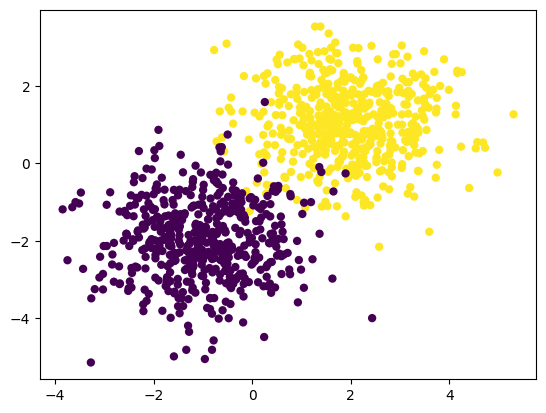

In [549]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,1.1])
X2 = np.random.randn(N,2) + np.array([-1.0,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])
Y = np.array(Y, dtype=np.int32)

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')
len(X) == len(Y)

In [550]:
net = Sequential()
net.add(Linear(2, 2))
net.add(SoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(LogSoftMax())

Linear 2 -> 2
SoftMax



In [551]:
# Optimizer params
optimizer_config = {'learning_rate' : 1e-1}
optimizer_state = {}

# Looping params
n_epoch = 3
batch_size = 64
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
    print( len(X), len(Y))
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

Training nn

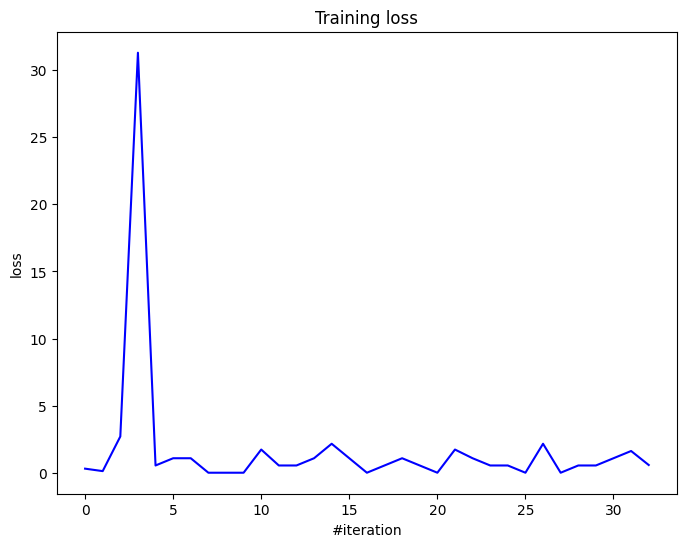

Current loss: 0.575646
[0.3028690828306692, 0.11972793319507824, 2.700859367627878, 31.30076610788781, 0.5396683811704803, 1.0793367623409598, 1.0793367623409595, 9.992007221626415e-16, 9.992007221626415e-16, 9.992007221626415e-16, 1.7269388197455346, 0.5396683811704803, 0.5396683811704803, 1.0793367623409598, 2.1586735246819186, 1.0793367623409595, 9.992007221626415e-16, 0.5396683811704803, 1.0793367623409595, 0.5396683811704804, 9.992007221626415e-16, 1.7269388197455346, 1.0793367623409598, 0.5396683811704803, 0.5396683811704804, 9.992007221626415e-16, 2.1586735246819186, 9.992007221626415e-16, 0.5396683811704804, 0.5396683811704804, 1.0793367623409598, 1.6190051435114392, 0.5756462732485124]


In [552]:
from sklearn.model_selection import train_test_split
print( len(X), len(Y))
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, shuffle=True, test_size=0.3 )
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X_train, Y_train), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        print( "predictions", predictions)
        loss = criterion.forward(predictions, y_batch)
        print( loss )
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        # Update weights
        simple_sgd(net.getParameters(), 
                   net.getGradParameters(), 
                   optimizer_config,
                   optimizer_state)      
        
        loss_history.append(loss)
    
    # Visualize
    from IPython.display import clear_output
    clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss) 
print(loss_history)

Comparing perfomance with already implemented models from sklearn

In [553]:
from sklearn.metrics import accuracy_score

net.train = False
net.zeroGradParameters()
        
# Forward
predictions_prob = net.forward(X_test)
print( len(predictions_prob) )
predictions = (predictions_prob > 0.5).astype(int)
# print( predictions[:5], Y_test[:5])
accuracy_score(predictions, Y_test)

300


0.9933333333333333

In [554]:
from sklearn.linear_model import LogisticRegression

lg = LogisticRegression().fit( X_train, Y_train[:,0])
lg.score( X_test, Y_test[:,0])

0.9866666666666667